In [1]:
import math

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sn

from tqdm import notebook

In [2]:
def set_seed_everywhere(seed, cuda = True):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [3]:
SEED = 1668
set_seed_everywhere(SEED)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### Adathalmaz letöltése

Az adathalmaz a CIFAR10. 10 osztályba tartozó képekből áll.

Az osztályok:
- repülőgép
- autó
- madár 
- macska
- szarvas
- kutya
- béka
- ló   
- hajó
- teherautó   

Az adathalmazban 60000 kép van, minden osztályhoz 6000 tartozik. Eredetileg 50000 kép van tanításra szánva, a maradék 10000 pedig tesztelésre.

A képek 3x32x32 méretűek, azaz 3 csatornás színes képek, 32x32 pixel méretűek.

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


In [6]:
X = [entry[0] for entry in trainset] + [entry[0] for entry in testset]
y = [entry[1] for entry in trainset] + [entry[1] for entry in testset]

### Képek megjelenítése

Minden kategóriába tartozó első tíz képnek az összeszedése

In [7]:
indices = []

for i in range(10):
    indices.append([idx for idx, v in enumerate(y) if v == i][:10])

Az összegyűjtött indexeken levő képek összeszedése egy tömbbe

In [8]:
images = []
for i in range(10):
    for j in indices[i]:
        images.append(X[j].tolist())

A képek megjelenítésére használt függvény

In [9]:
def imshow(img):
    npimg = img.detach().numpy()
    plt.figure(figsize=(15, 8), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

A képekből álló tömb megjelenítése. Az azonos sorban levő képek azonos kategóriába tartoznak

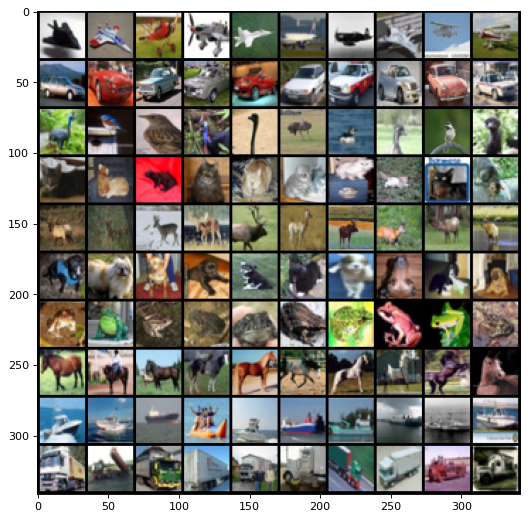

In [10]:
tensor = torch.FloatTensor(images)
imshow(torchvision.utils.make_grid(tensor, nrow = 10))

### Az adathalmaz három részre osztása

Az adathalmaz eredetileg két részre volt osztva, tanuló és tesztelő adathalmazra. Emellett az halmazok mérete is fix volt. Ezeket szeretném módosítani.

A túltanulás elkerülése érdekében bevezetem a validáló adathalmazt, illetve a halmazok méretét is beállítom.

A szétbontáshoz az sklearn *train_test_split* függvényét használtam. Ez a függvény két részre bontja az adathalmazt, ezért kétszer kell használnom. A teljes adathalmazból leválasztottam először a tesztelő halmazt, majd a maradékot szétosztom a tanuló- és validáló halmazt.

In [11]:
test_ratio = 0.15
valid_ratio = 0.15

valid_ratio = valid_ratio / (1.0 - test_ratio)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state = SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = valid_ratio, random_state = SEED)

In [13]:
print(f"Tanuló adathalmaz mérete: {len(X_train)}")
print(f"Tesztelő adathalmaz mérete: {len(X_test)}")
print(f"Validáló adathalmaz mérete: {len(X_val)}")

Tanuló adathalmaz mérete: 42000
Tesztelő adathalmaz mérete: 9000
Validáló adathalmaz mérete: 9000


Az előállított halmazok betöltése DataLoader-be, így könnyebben iterálható lesz az adat. Minden iteráció *batch_size* darab képet és címkét ad vissza.

In [14]:
trainset = [(X_train[idx], y_train[idx]) for idx in range(len(X_train))]
validset = [(X_val[idx], y_val[idx]) for idx in range(len(X_val))]
testset = [(X_test[idx], y_test[idx]) for idx in range(len(X_test))]

In [15]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Konvolúciós rétegek hatásának bemutatása

Egy konvolúciós réteg eredményét nem lehet közvetlenül megjeleníteni. A konvolúciós réteg eredménye több csatornából fog állni. Ezt az egy többcsatornás eredményt átalakítom több egycsatornás képpé. (Lehet lehetne egyszerűbben)

In [16]:
def cnn_result_to_tensor(result):
    image_list = []
    for i in result[0]:
        image_list.append([i.tolist()])
    tensor = torch.FloatTensor(image_list)
    return tensor

In [17]:
def create_image_representation(conv_layers, inputs):
    result = F.relu(inputs)
    imshow(torchvision.utils.make_grid(result))

    for conv in conv_layers:
        result = F.relu(conv(result))
        tensor = cnn_result_to_tensor(result)
        imshow(torchvision.utils.make_grid(tensor))

A később használt neurális hálók konvolúciós rétegei:

In [18]:
setups = [
    [nn.Conv2d(3, 6, 3), nn.Conv2d(6, 16, 3)],
    [nn.Conv2d(3, 6, 5), nn.Conv2d(6, 16, 5)],
    [nn.Conv2d(3, 4, 3), nn.Conv2d(4, 8, 3)],
    [nn.Conv2d(3, 32, 3), nn.Conv2d(32, 64, 3), nn.Conv2d(64, 128, 3)]
]

Az egyes konvolúciós neurális hálok konvolúciós rétegei által adott eredmények reprezentálása egy kiválasztott képen

Representation of setup #1


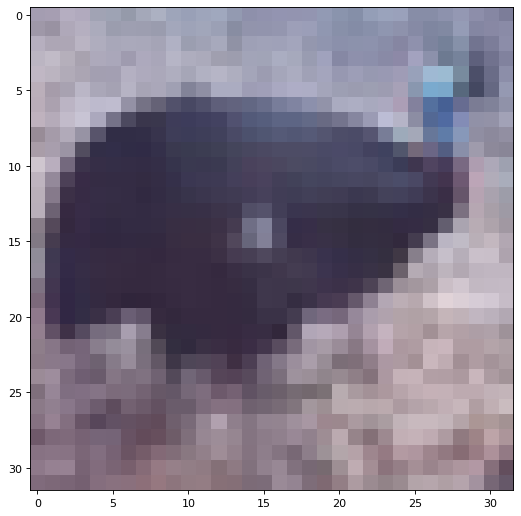

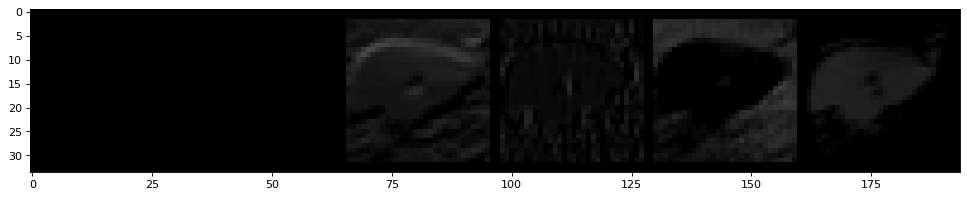

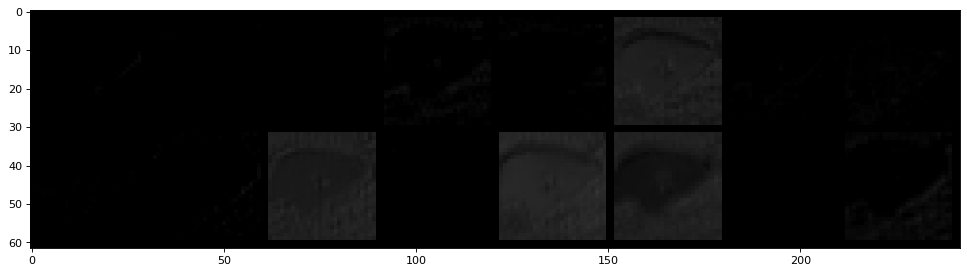

Representation of setup #2


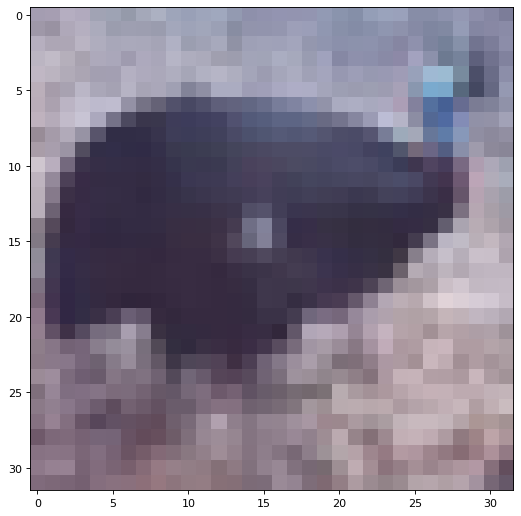

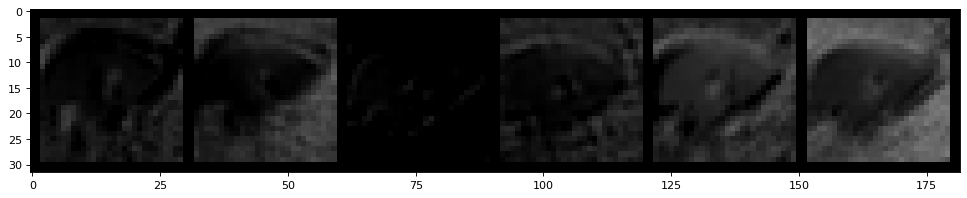

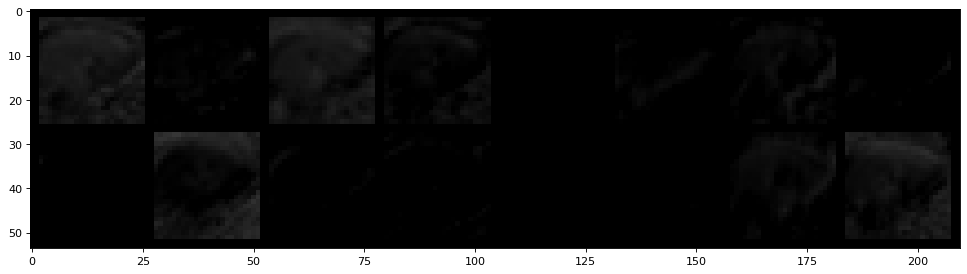

Representation of setup #3


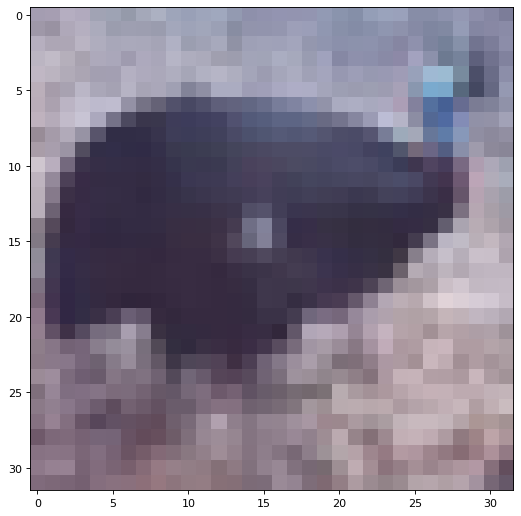

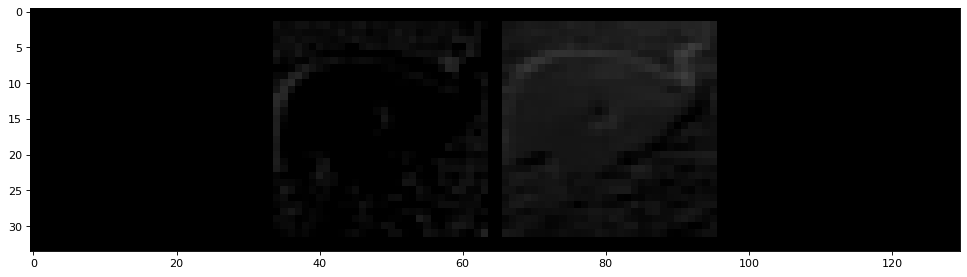

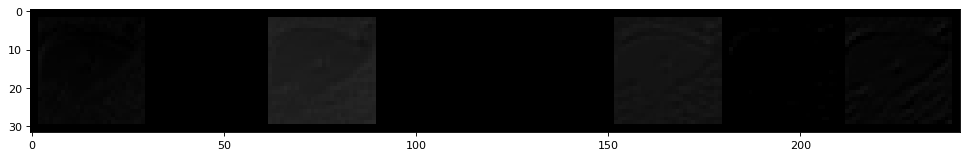

Representation of setup #4


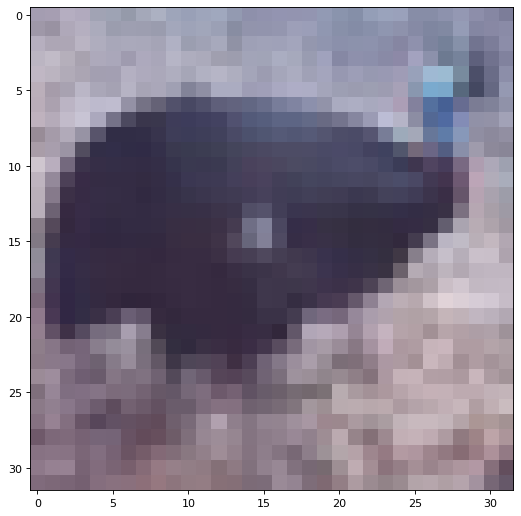

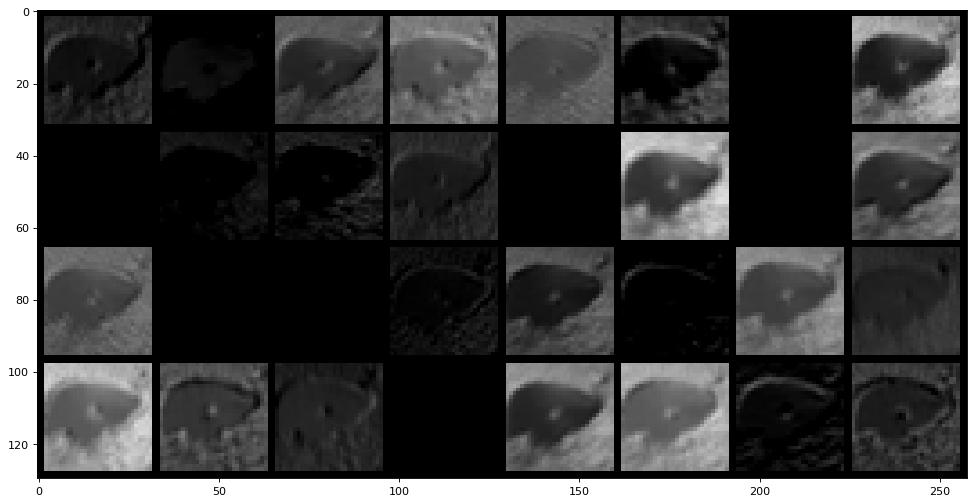

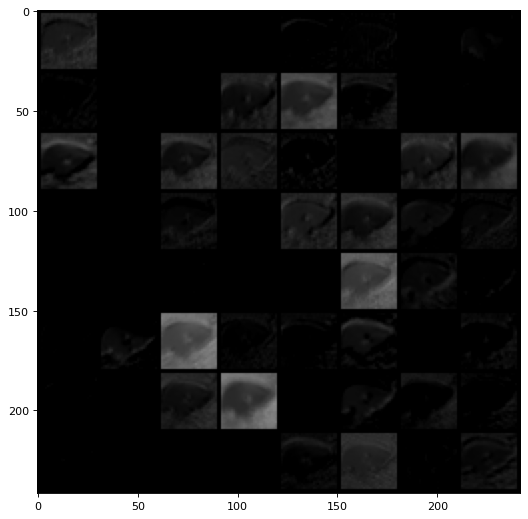

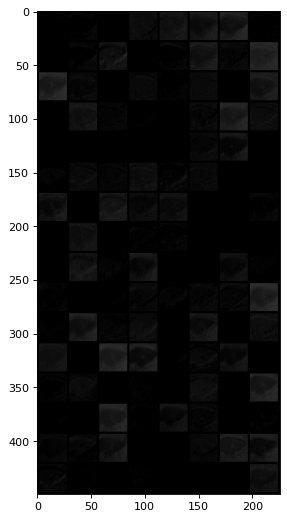

In [31]:
input_ = torch.unsqueeze(X_train[3], 0)

for idx, setup in enumerate(setups):
    print(f"Representation of setup #{idx + 1}")
    create_image_representation(setup, torch.FloatTensor(input_))

In [14]:
class CNN(nn.Module):
    def __init__(self, conv, fc, pool):
        super().__init__()
        self.conv = nn.ModuleList([c for c in conv])
        self.fc = nn.ModuleList([f for f in fc])
        self.pool = pool

    def forward(self, x):
        for conv in self.conv:
            x = self.pool(F.relu(conv(x)))

        x = torch.flatten(x, 1)
        
        for idx in range(len(self.fc) - 1):
           x = F.relu(self.fc[idx](x))
        
        x = self.fc[len(self.fc) - 1](x)
        
        return x

In [15]:
def class_accuracy(preds, y):
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [16]:
def train(model, iterator, optimizer, criterion, bar):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for idx, data in enumerate(iterator):
        
        inputs, labels = data

        optimizer.zero_grad()

        inputs = inputs.cuda() if use_cuda else inputs
        labels = labels.cuda() if use_cuda else labels
                
        predictions = model(inputs)

        acc = class_accuracy(predictions, labels)

        loss = criterion(predictions, labels)       
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        bar.set_postfix(loss=epoch_loss / (idx + 1))
        bar.set_postfix(acc=epoch_acc / (idx + 1))
        bar.update()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, bar):
    
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    predictions_list = []

    with torch.no_grad():
    
        for idx, batch in enumerate(iterator):
            inputs, labels = batch

            inputs = inputs.cuda() if use_cuda else inputs
            labels = labels.cuda() if use_cuda else labels
            
            predictions = model(inputs)
            predictions_list += predictions

            loss = criterion(predictions, labels)

            acc = class_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            bar.set_postfix(loss=epoch_loss / (idx + 1))
            bar.set_postfix(acc=epoch_acc / (idx + 1))
            bar.update()

    return epoch_loss / len(iterator), epoch_acc / len(iterator),  predictions_list

In [18]:
epochs = 45

`[(W−K+2P)/S]+1`

- W is the input volume  
- K is the Kernel size
- P is the padding
- S is the stride   

In [19]:
setups = [
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 16 * 6 * 6
    (   
        [nn.Conv2d(3, 6, 3), nn.Conv2d(6, 16, 3)],
        [nn.Linear(16 * 6 * 6, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.MaxPool2d(2, 2)
    ),
    # 32 - 5 + 0 / 1 + 1 = 28 / 2 = 14
    # 14 - 5 + 0 / 1 + 1 = 10 / 2 = 5
    # 16 * 5 * 5
    (
        [nn.Conv2d(3, 6, 5), nn.Conv2d(6, 16, 5)],
        [nn.Linear(16 * 5 * 5, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.MaxPool2d(2, 2)
    ),
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 8 * 6 * 6
    (
        [nn.Conv2d(3, 4, 3), nn.Conv2d(4, 8, 3)],
        [nn.Linear(8 * 6 * 6, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.AvgPool2d(2, 2)
    ),
    (
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 6 - 3 + 0 / 1 + 1 = 4 / 2 = 2
    # 128 * 2 * 2
        [nn.Conv2d(3, 32, 3), nn.Conv2d(32, 64, 3), nn.Conv2d(64, 128, 3)],
        [nn.Linear(128 * 2 * 2, 128), nn.Linear(128, 64), nn.Linear(64, 32), nn.Linear(32, 10)],
        nn.MaxPool2d(2, 2)
    )
]

In [24]:
def top_n_result(prediction, n = 1):
    result = []
    for idx in range(len(prediction)):
        topk = torch.topk(prediction[idx], n).indices.tolist()
        result.append(topk)
    return result

In [25]:
def top_n_accuracy(target, prediction, n = 1):
    correct_predictions = 0
    
    top_n_pred = top_n_result(prediction, n)

    for idx in range(len(target)):
        if target[idx] in top_n_pred[idx]:
            correct_predictions += 1
    
    return correct_predictions / len(target)

In [26]:
def get_target(loader):
    target = []
    
    for batch in loader:
        inputs, labels = batch
        target += labels
    
    return target

In [23]:
test_target = get_target(testloader)

In [25]:
epoch_bar = notebook.tqdm(desc='training routine', total=epochs, position=0)
train_bar = notebook.tqdm(desc='train', total=len(trainloader),position=0,leave=True)
val_bar = notebook.tqdm(desc='valid',total=len(validloader), position=0, leave=True)

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

for setup_idx, setup in enumerate(setups):    
    epoch_bar.n = 0
    train_bar.n = 0
    val_bar.n = 0
    
    epoch_bar.refresh()
    train_bar.refresh()
    val_bar.refresh()

    conv, fc, pool = setup
    cnn = CNN(conv, fc, pool)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    cnn = cnn.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    train_accs.append([])
    valid_accs.append([])
    train_losses.append([])
    valid_losses.append([])
    
    # Training
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        t_loss, t_acc = train(cnn, trainloader, optimizer, criterion, train_bar)
        v_loss, v_acc, _ = evaluate(cnn, validloader, criterion, val_bar)
        
        train_accs[setup_idx].append(t_acc)
        valid_accs[setup_idx].append(v_acc)

        if v_loss < best_valid_loss:
            best_valid_loss = v_loss
            model_name = f"CNN_#{setup_idx}"
            torch.save(cnn.state_dict(), model_name)

        train_losses[setup_idx].append(t_loss)
        valid_losses[setup_idx].append(v_loss)

        train_bar.n = 0
        val_bar.n = 0 
        
        train_bar.refresh()
        val_bar.refresh()
        epoch_bar.update()

training routine:   0%|          | 0/45 [00:00<?, ?it/s]

train:   0%|          | 0/10500 [00:00<?, ?it/s]

valid:   0%|          | 0/2250 [00:00<?, ?it/s]

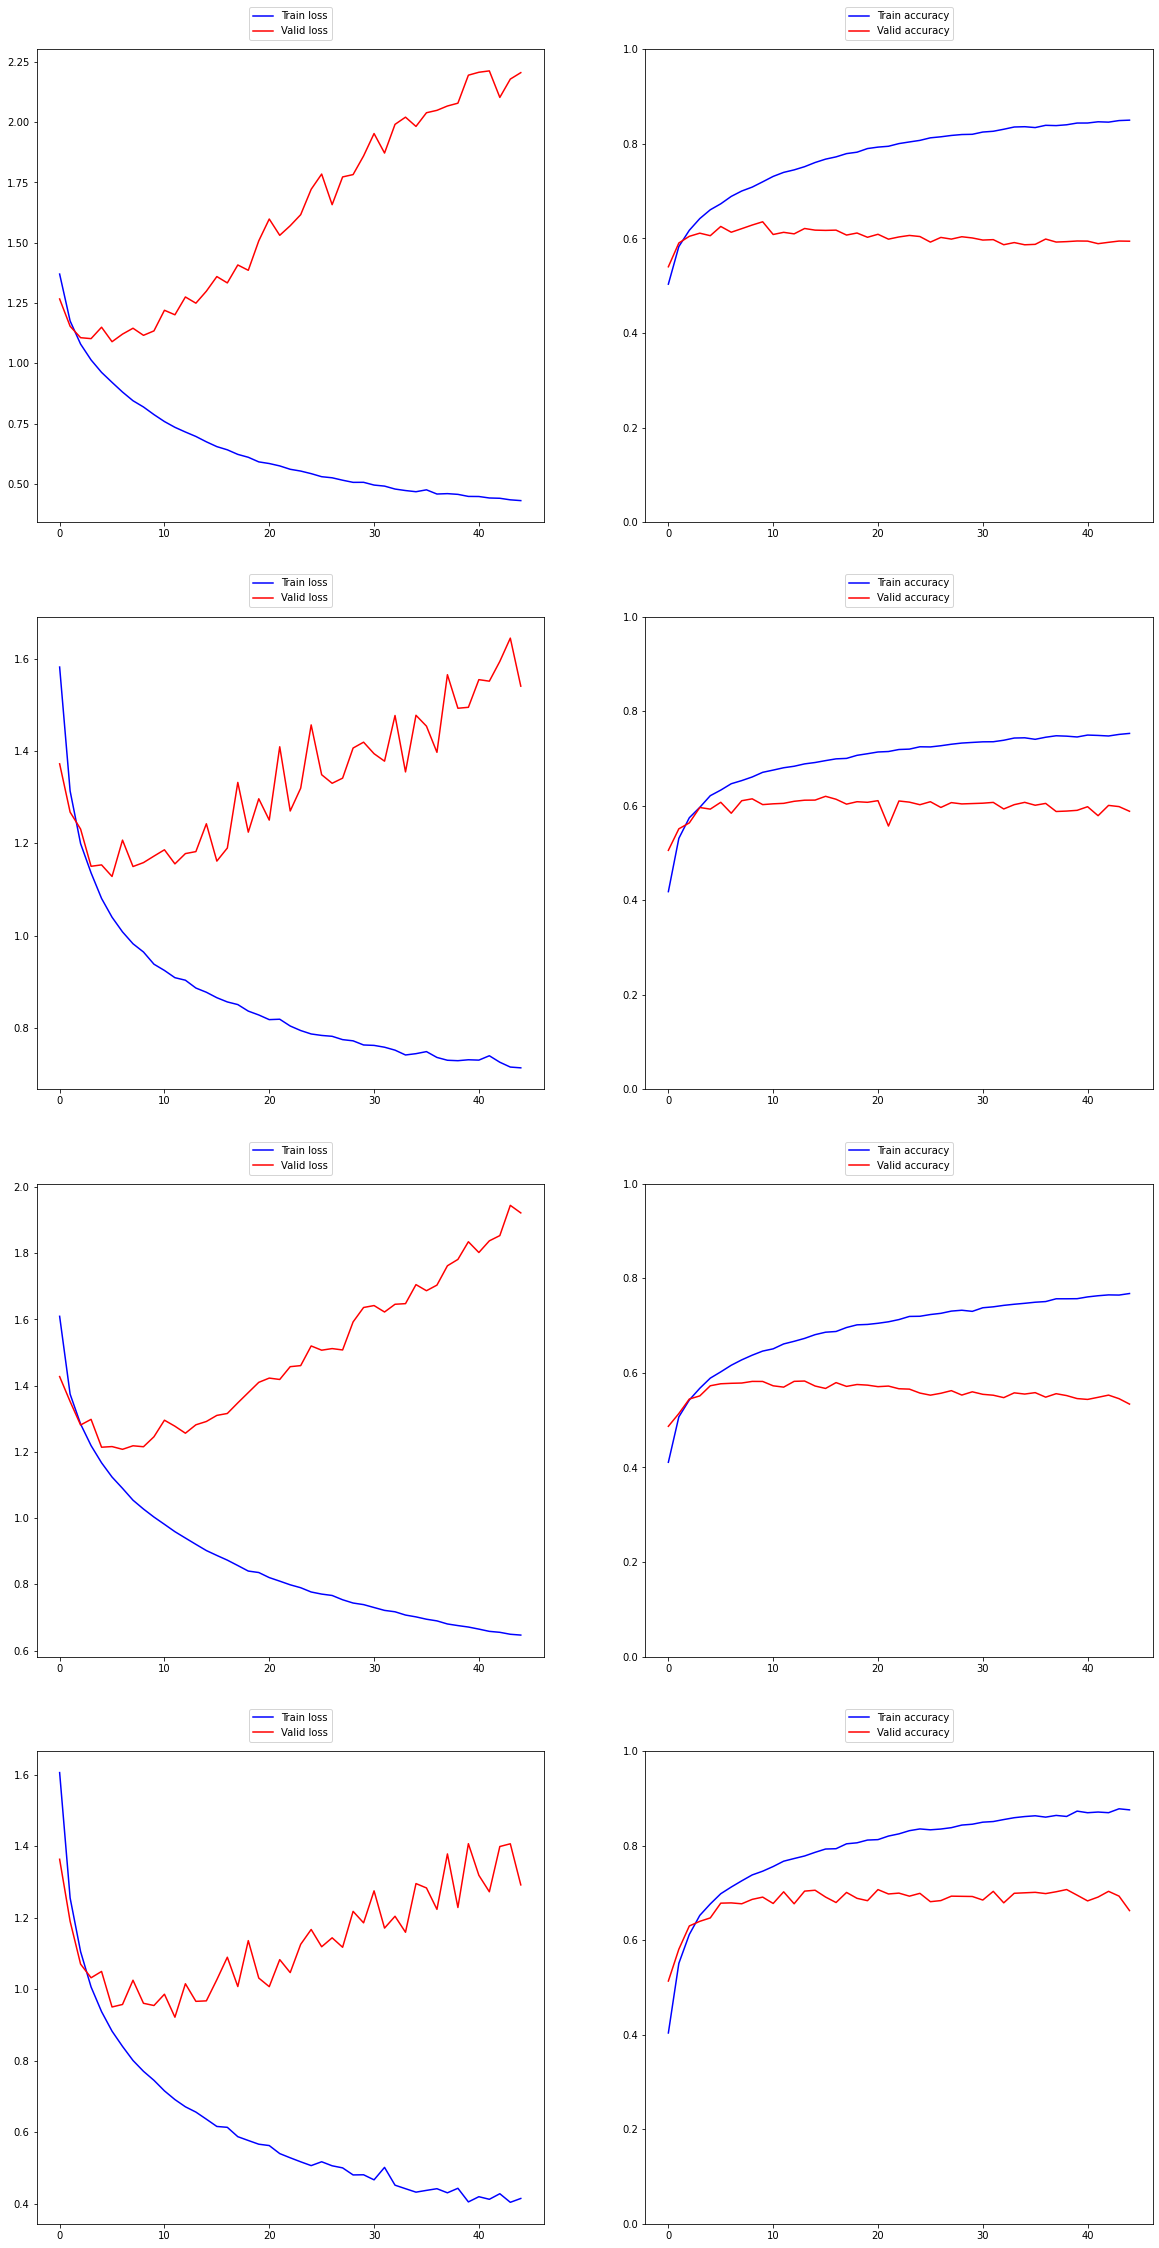

In [26]:
fig, axs = plt.subplots(len(setups), 2, figsize=(10 * 2, 10 * len(setups)))

for setup_idx in range(len(setups)):
    axs[setup_idx, 0].plot([*range(epochs)], train_losses[setup_idx], color = 'b', label='Train loss')
    axs[setup_idx, 0].plot([*range(epochs)], valid_losses[setup_idx], color = 'r', label='Valid loss')
    axs[setup_idx, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1)
    
    axs[setup_idx, 1].axis(ymin = 0, ymax = 1)
    axs[setup_idx, 1].plot([*range(epochs)], train_accs[setup_idx], color = 'b', label='Train accuracy')
    axs[setup_idx, 1].plot([*range(epochs)], valid_accs[setup_idx], color = 'r', label='Valid accuracy')
    axs[setup_idx, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1)
    
plt.show()

test:   0%|          | 0/2250 [00:00<?, ?it/s]

Setup #1
Top 1 accuracy: 62%
Top 2 accuracy: 80%
Top 3 accuracy: 88%
Setup #2
Top 1 accuracy: 60%
Top 2 accuracy: 78%
Top 3 accuracy: 86%
Setup #3
Top 1 accuracy: 56%
Top 2 accuracy: 75%
Top 3 accuracy: 84%
Setup #4
Top 1 accuracy: 69%
Top 2 accuracy: 84%
Top 3 accuracy: 90%


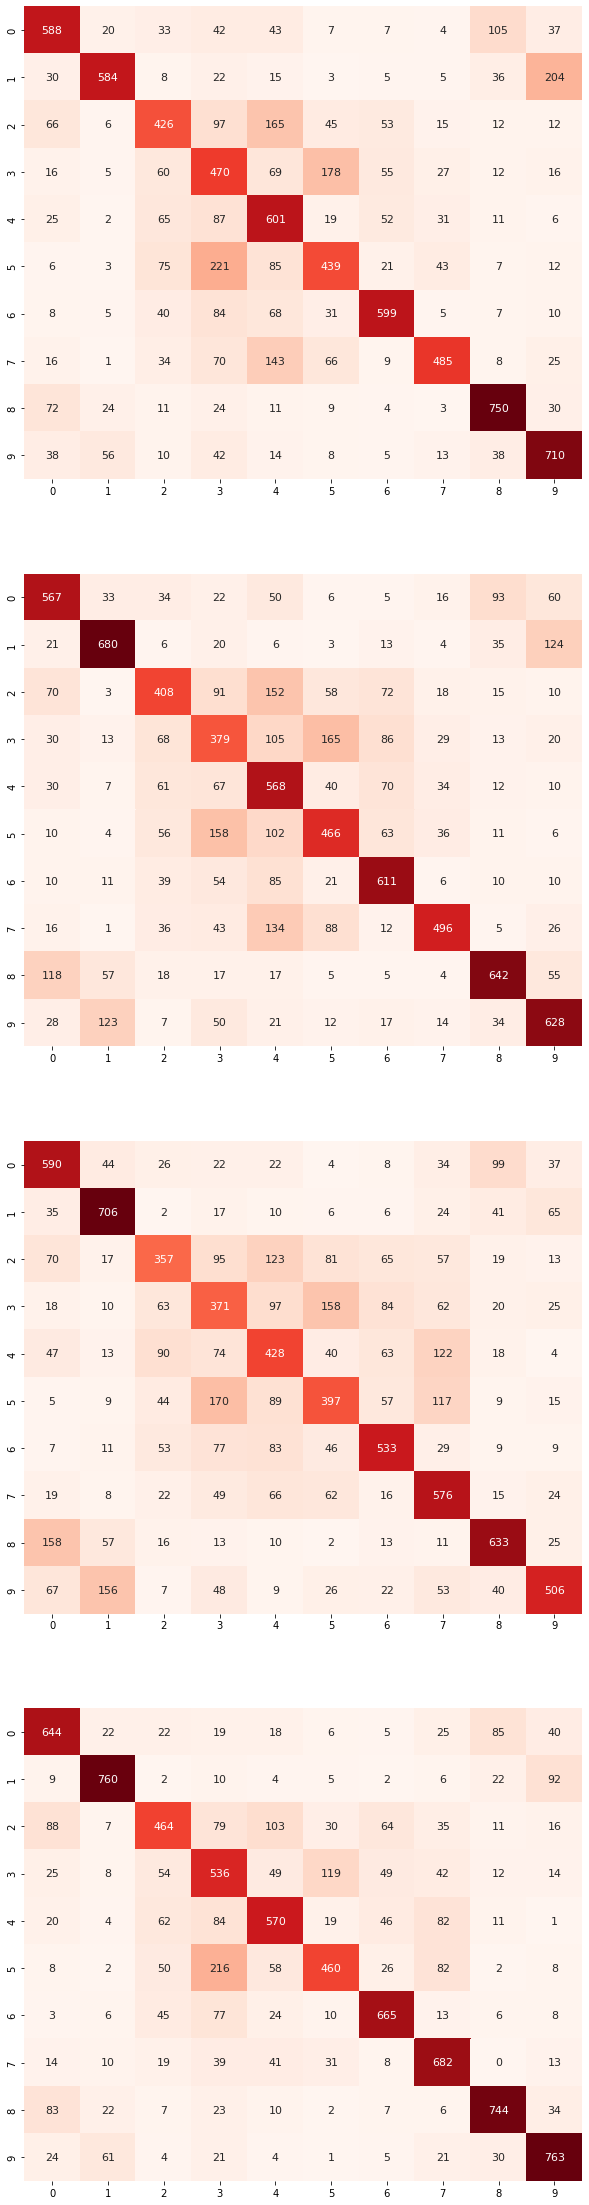

In [27]:
fig, axs = plt.subplots(len(setups), 1, figsize=(10 * 1, 10 * len(setups)))

test_bar = notebook.tqdm(desc='test', total=len(testloader), position=0, leave=True)

for setup_idx, setup in enumerate(setups):
    test_bar.n = 0
    test_bar.refresh()

    print("=========================")
    print(f"Setup #{setup_idx + 1}")
    
    conv, fc, pool = setup
    cnn = CNN(conv, fc, pool)
    
    model_name = f"CNN_#{setup_idx}"
    cnn.load_state_dict(torch.load(model_name))
    _, __, total_predictions = evaluate(cnn, testloader, criterion, test_bar)

    predictions = top_n_result(total_predictions, 1)
    
    cm = confusion_matrix(test_target, predictions)
    heatmap = sn.heatmap(cm, annot=True, cmap='Reds', ax=axs[setup_idx], fmt='g', annot_kws={"size": 11}, cbar=False)
    
    for k in range(1, 4):
        print(f"Top {k} accuracy: {math.trunc(top_n_accuracy(test_target, total_predictions, k) * 100)}%")

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

In [20]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(64)
        
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [27]:
epochs = 10

In [31]:
epoch_bar = notebook.tqdm(desc='training routine', total=epochs, position=0)
train_bar = notebook.tqdm(desc='train', total=len(trainloader),position=0,leave=True)
val_bar = notebook.tqdm(desc='valid',total=len(validloader), position=0, leave=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

clf = ResNet()

clf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.001)

best_valid_loss = float('inf')

for epoch in range(epochs):
    t_loss, t_acc = train(clf, trainloader, optimizer, criterion, train_bar)
    v_loss, v_acc, _ = evaluate(clf, validloader, criterion, val_bar)
    
    print(f"Epoch #{epoch}\nValidation loss: {v_loss} Accuracy: {v_acc}")
    if v_loss < best_valid_loss:
        best_valid_loss = v_loss
        model_name = f"ResNet"
        torch.save(clf.state_dict(), model_name)

    train_bar.n = 0
    val_bar.n = 0 
        
    train_bar.refresh()
    val_bar.refresh()
    epoch_bar.update()

training routine:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/10500 [00:00<?, ?it/s]

valid:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch #0
Validation loss: 1.0737728944321474 Accuracy: 0.6238888888888889
Epoch #1
Validation loss: 0.7765214068045219 Accuracy: 0.7307777777777777
Epoch #2
Validation loss: 0.6243502263084519 Accuracy: 0.7835555555555556
Epoch #3
Validation loss: 0.5846295839103146 Accuracy: 0.8003333333333333
Epoch #4
Validation loss: 0.5466398294029641 Accuracy: 0.8183333333333334
Epoch #5
Validation loss: 0.6887677859667634 Accuracy: 0.7913333333333333
Epoch #6
Validation loss: 0.5855629378610689 Accuracy: 0.8244444444444444
Epoch #7
Validation loss: 0.650455638555723 Accuracy: 0.8186666666666667
Epoch #8
Validation loss: 0.6649813490441217 Accuracy: 0.8195555555555556
Epoch #9
Validation loss: 0.7174400452617782 Accuracy: 0.8221111111111111


In [28]:
test_target = get_target(testloader)

test:   0%|          | 0/2250 [00:00<?, ?it/s]

Top 1 accuracy: 81%
Top 2 accuracy: 92%
Top 3 accuracy: 96%


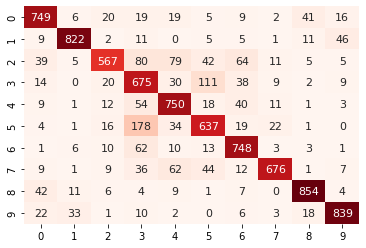

In [30]:
test_bar = notebook.tqdm(desc='test', total=len(testloader), position=0, leave=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

clf = ResNet()
clf.to(device)    

criterion = nn.CrossEntropyLoss()

model_name = f"ResNet"

clf.load_state_dict(torch.load(model_name))
_, __, total_predictions = evaluate(clf, testloader, criterion, test_bar)

predictions = top_n_result(total_predictions, 1)
    
cm = confusion_matrix(test_target, predictions)
heatmap = sn.heatmap(cm, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 11}, cbar=False)
    
for k in range(1, 4):
    print(f"Top {k} accuracy: {math.trunc(top_n_accuracy(test_target, total_predictions, k) * 100)}%")